<a href="https://colab.research.google.com/github/miguelgargallo/chatPylarAI/blob/main/chatPylarAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [5]:
#importing the dataset
with open('content.json') as content:
  data1 = json.load(content)

In [6]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [7]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [8]:
#printing the data
data

,inputs,tags
0,hola,greeting
1,buenas,greeting
2,hey,greeting
3,morning,greeting
4,afternoon,greeting
...,...,...
64,me he perdido,llegada
65,me he perdido en el camino,llegada
66,me he perdido en el camino al lugar,llegada
67,me he perdido en el camino al evento,llegada


In [9]:
data = data.sample(frac=1)

In [10]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
4,afternoon,greeting
55,como llegar a la campaña,llegada
54,como llegar al evento,llegada
48,perdido,llegada
41,como he de ir al evento,requirements
...,...,...
13,nose,help
0,hola,greeting
16,fecha,campaign
30,nose donde es,location


In [11]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [12]:
input_shape = x_train.shape[1]
print(input_shape)

9


In [13]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  55
output length:  7


In [14]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

In [15]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [16]:
#training the model
train = model.fit(x_train,y_train,epochs=400)

Epoch 1/400
3/3 [==============================] - 2s 8ms/step - loss: 1.9404 - accuracy: 0.2029
Epoch 2/400
3/3 [==============================] - 0s 9ms/step - loss: 1.9350 - accuracy: 0.3188
Epoch 3/400
3/3 [==============================] - 0s 7ms/step - loss: 1.9294 - accuracy: 0.3188
Epoch 4/400
3/3 [==============================] - 0s 8ms/step - loss: 1.9237 - accuracy: 0.3623
Epoch 5/400
3/3 [==============================] - 0s 9ms/step - loss: 1.9178 - accuracy: 0.3623
Epoch 6/400
3/3 [==============================] - 0s 8ms/step - loss: 1.9109 - accuracy: 0.3623
Epoch 7/400
3/3 [==============================] - 0s 9ms/step - loss: 1.9034 - accuracy: 0.3623
Epoch 8/400
3/3 [==============================] - 0s 8ms/step - loss: 1.8953 - accuracy: 0.3623
Epoch 9/400
3/3 [==============================] - 0s 9ms/step - loss: 1.8854 - accuracy: 0.3478
Epoch 10/400
3/3 [==============================] - 0s 10ms/step - loss: 1.8761 - accuracy: 0.3188
Epoch 11/400
3/3 [==========

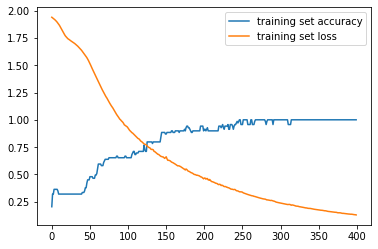

In [17]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [19]:
#chatting
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Going Merry : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You : hola
1/1 [==============================] - 0s 16ms/step
Going Merry :  Que tal! En que puedo ayudarte?
You : ubicacion
1/1 [==============================] - 0s 17ms/step
Going Merry :  El lugar de la campaña es en el Bar Manolo, en el centro de la ciudad
You : adios
1/1 [==============================] - 0s 20ms/step
Going Merry :  Que tengas un buen dia!
